In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
filename="/content/drive/My Drive/HAM10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")


done


In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
train_df = pd.read_csv('/code/MyCode/AUG/HAM10000/train.csv')
test_df = pd.read_csv('/code/MyCode/AUG/HAM10000/test.csv')

In [4]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [5]:
train_path = '/code/MyCode/AUG/HAM10000/train_dir'
test_path = '/code/MyCode/AUG/HAM10000/test_dir'
batch_size=16

In [6]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [7]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 55115 images belonging to 7 classes.

Test Batches: 
Found 2003 images belonging to 7 classes.


In [8]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [9]:

irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last 28 layers of the model.
conv = irv2.layers[-28].output


Soft Attention

In [10]:


attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


In [11]:

output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)

In [14]:
#model.summary()

In [15]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [16]:
checkpoint=  ModelCheckpoint(filepath ='/content/drive/My Drive/IRV2+SA.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [17]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=30, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=50,
                    verbose=2,
                    validation_data=test_batches,validation_steps=len(test_df)/batch_size,callbacks=[checkpoint,Earlystop])

Epoch 1/50
801/801 - 582s - loss: 1.0644 - accuracy: 0.6061 - val_loss: 0.9990 - val_accuracy: 0.5911 - 582s/epoch - 727ms/step
Epoch 2/50
801/801 - 513s - loss: 0.6683 - accuracy: 0.7581 - val_loss: 0.6163 - val_accuracy: 0.7728 - 513s/epoch - 640ms/step
Epoch 3/50
801/801 - 485s - loss: 0.5253 - accuracy: 0.8123 - val_loss: 1.0223 - val_accuracy: 0.7179 - 485s/epoch - 605ms/step
Epoch 4/50
801/801 - 485s - loss: 0.4151 - accuracy: 0.8519 - val_loss: 0.6519 - val_accuracy: 0.7723 - 485s/epoch - 605ms/step
Epoch 5/50
801/801 - 492s - loss: 0.3674 - accuracy: 0.8689 - val_loss: 0.5328 - val_accuracy: 0.8193 - 492s/epoch - 615ms/step
Epoch 6/50
801/801 - 488s - loss: 0.3234 - accuracy: 0.8839 - val_loss: 0.5405 - val_accuracy: 0.8058 - 488s/epoch - 609ms/step
Epoch 7/50
801/801 - 485s - loss: 0.2831 - accuracy: 0.9019 - val_loss: 0.5132 - val_accuracy: 0.8123 - 485s/epoch - 605ms/step
Epoch 8/50
801/801 - 485s - loss: 0.2533 - accuracy: 0.9119 - val_loss: 0.5568 - val_accuracy: 0.8123 - 

Text(0.5, 1.0, 'Training and validation loss')

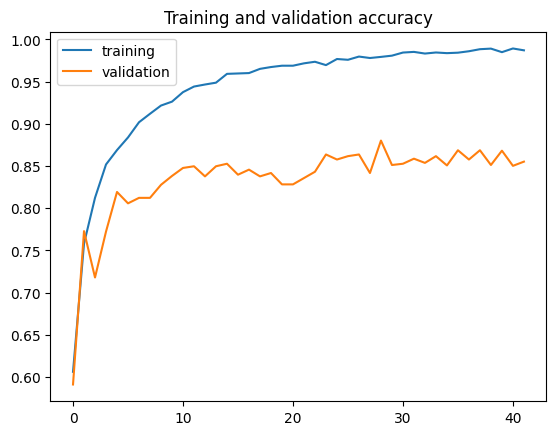

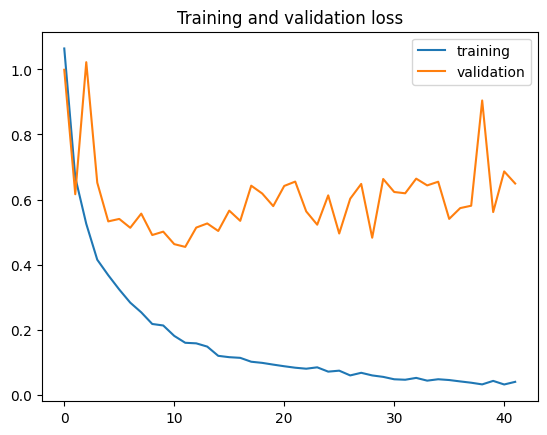

In [18]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [12]:
from tensorflow.keras import models
model.load_weights("IRV2+SA.hdf5")

In [13]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

In [13]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report IRV2+SA :")
print(report)


Classification Report IRV2+SA :
              precision    recall  f1-score   support

       akiec       0.77      0.83      0.80        65
         bcc       0.88      0.75      0.81       103
         bkl       0.82      0.70      0.76       220
          df       0.93      0.57      0.70        23
         mel       0.73      0.69      0.71       223
          nv       0.91      0.96      0.93      1341
        vasc       0.96      0.96      0.96        28

    accuracy                           0.88      2003
   macro avg       0.86      0.78      0.81      2003
weighted avg       0.88      0.88      0.88      2003



Text(55.172222222222274, 0.5, 'Pred Label')

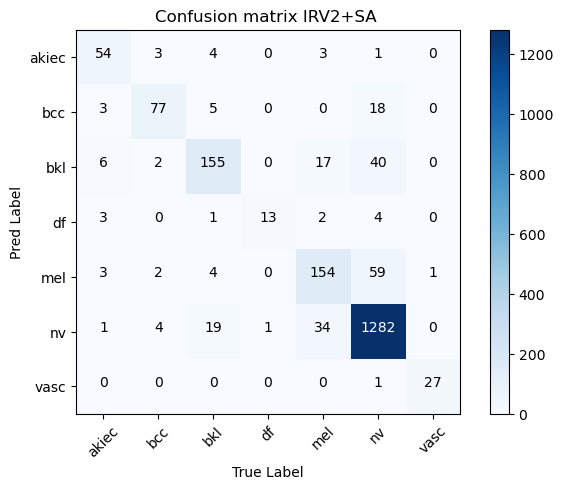

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix IRV2+SA ',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = targetnames)
plt.xlabel('True Label')
plt.ylabel('Pred Label')

In [15]:
print("Average = 'weighted'")
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

print("Average = 'macro'")
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

print("Average = 'micro'")
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='micro')))

Average = 'weighted'
Precision: 0.8772561952230787
Recall: 0.8796804792810784
Accuracy: 0.8796804792810784
Roc score: 0.9641307483029745
Average = 'macro'
Precision: 0.858506092677095
Recall: 0.7798537927040863
Accuracy: 0.8796804792810784
Roc score: 0.9784520568273875
Average = 'micro'
Precision: 0.8796804792810784
Recall: 0.8796804792810784
Accuracy: 0.8796804792810784
Roc score: 0.9880899652352061


In [16]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9877828054298643
The ROC AUC score of bcc is: 0.9894174757281554
The ROC AUC score of bkl is: 0.9652551878855861
The ROC AUC score of df is: 0.9956082564778217
The ROC AUC score of mel is: 0.9491887942762129
The ROC AUC score of nv is: 0.9620565434551931
The ROC AUC score of vasc is: 0.9998553345388789


In [17]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

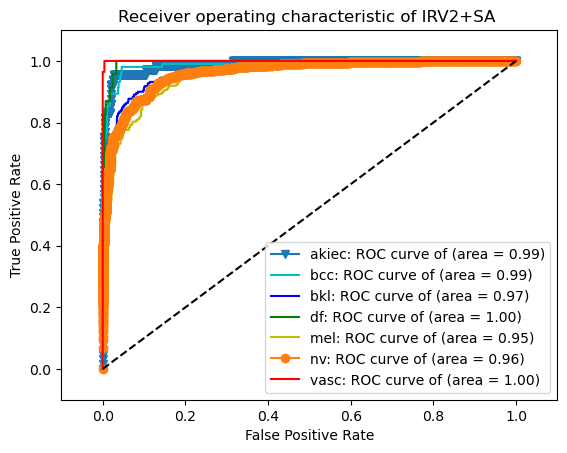

In [18]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of IRV2+SA ')
plt.legend(loc="lower right")
plt.show()

ATTENTION MAP

1/1 [==============================] - 2s 2s/step


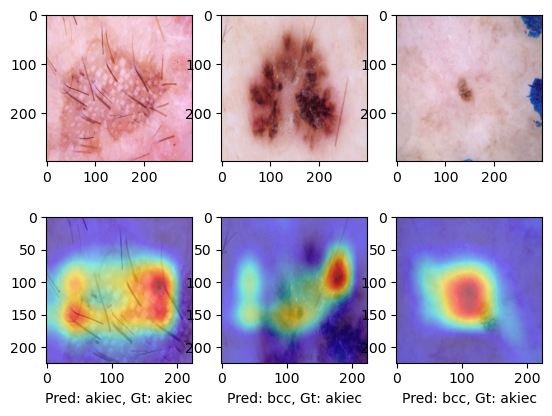

In [19]:
x_test,y_test=test_batches[1]
sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
img1_idx = 9
img2_idx = 4
img3_idx = 3
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
#plt.imshow(t[img_idx])
fig, axes = plt.subplots(2, 3)
axes[0,0].imshow(t[img1_idx])
axes[0,1].imshow(t[img2_idx])
axes[0,2].imshow(t[img3_idx])
#plt.show()




class_predictions = model.predict(x_test)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

###############################
prediction_index1 = np.argmax(class_predictions[9])
ground_truth_index1 = np.argmax(y_test[9])

pred1 = target_names[prediction_index1]
gt1 = target_names[ground_truth_index1]

###################################
prediction_index2 = np.argmax(class_predictions[4])
ground_truth_index2 = np.argmax(y_test[4])

pred2 = target_names[prediction_index2]
gt2 = target_names[ground_truth_index2]

#######################################
prediction_index3 = np.argmax(class_predictions[3])
ground_truth_index3 = np.argmax(y_test[3])

pred3 = target_names[prediction_index3]
gt3 = target_names[ground_truth_index3]


#################
#fig, axes = plt.subplots(1, 3)

sum_attnmap = np.sum(sa_maps[img1_idx],0)
axes[1,0].imshow(t[img1_idx],alpha=1.0)
axes[1,0].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,0].set_xlabel(f"Pred: {pred1}, Gt: {gt1}")

sum_attnmap = np.sum(sa_maps[img2_idx],0)
axes[1,1].imshow(t[img2_idx],alpha=1.0)
axes[1,1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,1].set_xlabel(f"Pred: {pred2}, Gt: {gt2}")

sum_attnmap = np.sum(sa_maps[img3_idx],0)
axes[1,2].imshow(t[img3_idx],alpha=1.0)
axes[1,2].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,2].set_xlabel(f"Pred: {pred3}, Gt: {gt3}")

plt.show()

1/1 [==============================] - 0s 162ms/step


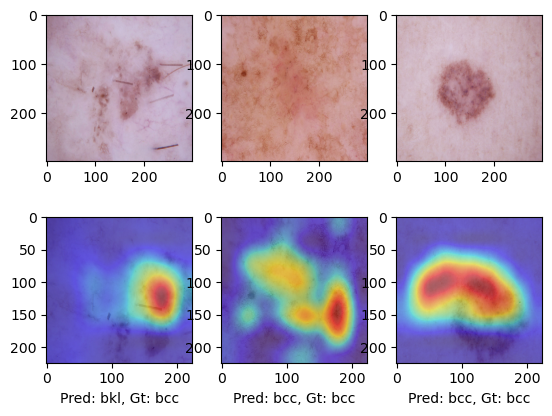

In [20]:
x_test,y_test=test_batches[9]



sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
img1_idx = 9
img2_idx = 4
img3_idx = 3
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
#plt.imshow(t[img_idx])
fig, axes = plt.subplots(2, 3)
axes[0,0].imshow(t[img1_idx])
axes[0,1].imshow(t[img2_idx])
axes[0,2].imshow(t[img3_idx])
#plt.show()




class_predictions = model.predict(x_test)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

###############################
prediction_index1 = np.argmax(class_predictions[9])
ground_truth_index1 = np.argmax(y_test[9])

pred1 = target_names[prediction_index1]
gt1 = target_names[ground_truth_index1]

###################################
prediction_index2 = np.argmax(class_predictions[4])
ground_truth_index2 = np.argmax(y_test[4])

pred2 = target_names[prediction_index2]
gt2 = target_names[ground_truth_index2]

#######################################
prediction_index3 = np.argmax(class_predictions[3])
ground_truth_index3 = np.argmax(y_test[3])

pred3 = target_names[prediction_index3]
gt3 = target_names[ground_truth_index3]


#################
#fig, axes = plt.subplots(1, 3)

sum_attnmap = np.sum(sa_maps[img1_idx],0)
axes[1,0].imshow(t[img1_idx],alpha=1.0)
axes[1,0].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,0].set_xlabel(f"Pred: {pred1}, Gt: {gt1}")

sum_attnmap = np.sum(sa_maps[img2_idx],0)
axes[1,1].imshow(t[img2_idx],alpha=1.0)
axes[1,1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,1].set_xlabel(f"Pred: {pred2}, Gt: {gt2}")

sum_attnmap = np.sum(sa_maps[img3_idx],0)
axes[1,2].imshow(t[img3_idx],alpha=1.0)
axes[1,2].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,2].set_xlabel(f"Pred: {pred3}, Gt: {gt3}")

plt.show()

1/1 [==============================] - 0s 141ms/step


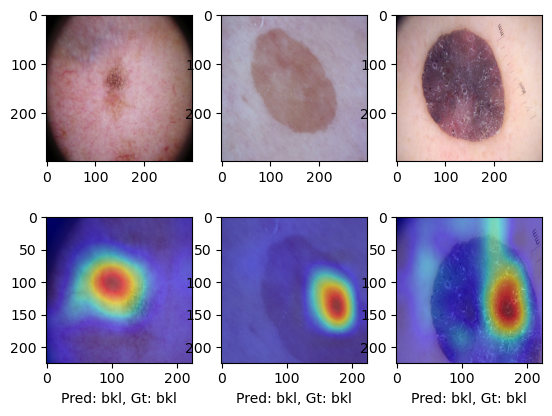

In [21]:
x_test,y_test=test_batches[23]



sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
img1_idx = 9
img2_idx = 4
img3_idx = 3
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
#plt.imshow(t[img_idx])
fig, axes = plt.subplots(2, 3)
axes[0,0].imshow(t[img1_idx])
axes[0,1].imshow(t[img2_idx])
axes[0,2].imshow(t[img3_idx])
#plt.show()




class_predictions = model.predict(x_test)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

###############################
prediction_index1 = np.argmax(class_predictions[9])
ground_truth_index1 = np.argmax(y_test[9])

pred1 = target_names[prediction_index1]
gt1 = target_names[ground_truth_index1]

###################################
prediction_index2 = np.argmax(class_predictions[4])
ground_truth_index2 = np.argmax(y_test[4])

pred2 = target_names[prediction_index2]
gt2 = target_names[ground_truth_index2]

#######################################
prediction_index3 = np.argmax(class_predictions[3])
ground_truth_index3 = np.argmax(y_test[3])

pred3 = target_names[prediction_index3]
gt3 = target_names[ground_truth_index3]


#################
#fig, axes = plt.subplots(1, 3)

sum_attnmap = np.sum(sa_maps[img1_idx],0)
axes[1,0].imshow(t[img1_idx],alpha=1.0)
axes[1,0].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,0].set_xlabel(f"Pred: {pred1}, Gt: {gt1}")

sum_attnmap = np.sum(sa_maps[img2_idx],0)
axes[1,1].imshow(t[img2_idx],alpha=1.0)
axes[1,1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,1].set_xlabel(f"Pred: {pred2}, Gt: {gt2}")

sum_attnmap = np.sum(sa_maps[img3_idx],0)
axes[1,2].imshow(t[img3_idx],alpha=1.0)
axes[1,2].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,2].set_xlabel(f"Pred: {pred3}, Gt: {gt3}")

plt.show()

1/1 [==============================] - 0s 156ms/step


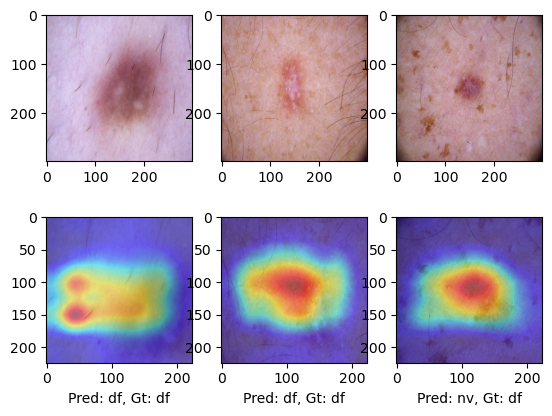

In [22]:
x_test,y_test=test_batches[25]



sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
img1_idx = 9
img2_idx = 4
img3_idx = 3
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
#plt.imshow(t[img_idx])
fig, axes = plt.subplots(2, 3)
axes[0,0].imshow(t[img1_idx])
axes[0,1].imshow(t[img2_idx])
axes[0,2].imshow(t[img3_idx])
#plt.show()




class_predictions = model.predict(x_test)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

###############################
prediction_index1 = np.argmax(class_predictions[9])
ground_truth_index1 = np.argmax(y_test[9])

pred1 = target_names[prediction_index1]
gt1 = target_names[ground_truth_index1]

###################################
prediction_index2 = np.argmax(class_predictions[4])
ground_truth_index2 = np.argmax(y_test[4])

pred2 = target_names[prediction_index2]
gt2 = target_names[ground_truth_index2]

#######################################
prediction_index3 = np.argmax(class_predictions[3])
ground_truth_index3 = np.argmax(y_test[3])

pred3 = target_names[prediction_index3]
gt3 = target_names[ground_truth_index3]


#################
#fig, axes = plt.subplots(1, 3)

sum_attnmap = np.sum(sa_maps[img1_idx],0)
axes[1,0].imshow(t[img1_idx],alpha=1.0)
axes[1,0].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,0].set_xlabel(f"Pred: {pred1}, Gt: {gt1}")

sum_attnmap = np.sum(sa_maps[img2_idx],0)
axes[1,1].imshow(t[img2_idx],alpha=1.0)
axes[1,1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,1].set_xlabel(f"Pred: {pred2}, Gt: {gt2}")

sum_attnmap = np.sum(sa_maps[img3_idx],0)
axes[1,2].imshow(t[img3_idx],alpha=1.0)
axes[1,2].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,2].set_xlabel(f"Pred: {pred3}, Gt: {gt3}")

plt.show()

1/1 [==============================] - 0s 135ms/step


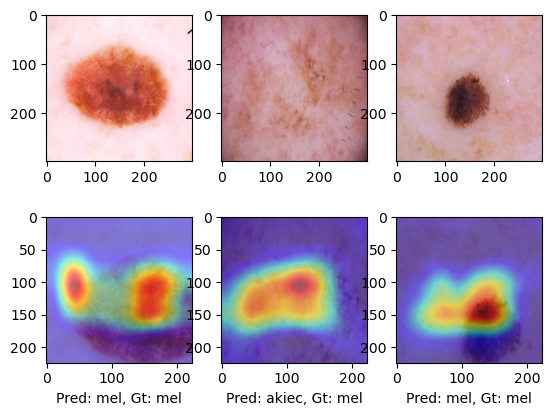

In [23]:
x_test,y_test=test_batches[33]



sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
img1_idx = 9
img2_idx = 4
img3_idx = 3
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
#plt.imshow(t[img_idx])
fig, axes = plt.subplots(2, 3)
axes[0,0].imshow(t[img1_idx])
axes[0,1].imshow(t[img2_idx])
axes[0,2].imshow(t[img3_idx])
#plt.show()




class_predictions = model.predict(x_test)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

###############################
prediction_index1 = np.argmax(class_predictions[9])
ground_truth_index1 = np.argmax(y_test[9])

pred1 = target_names[prediction_index1]
gt1 = target_names[ground_truth_index1]

###################################
prediction_index2 = np.argmax(class_predictions[4])
ground_truth_index2 = np.argmax(y_test[4])

pred2 = target_names[prediction_index2]
gt2 = target_names[ground_truth_index2]

#######################################
prediction_index3 = np.argmax(class_predictions[3])
ground_truth_index3 = np.argmax(y_test[3])

pred3 = target_names[prediction_index3]
gt3 = target_names[ground_truth_index3]


#################
#fig, axes = plt.subplots(1, 3)

sum_attnmap = np.sum(sa_maps[img1_idx],0)
axes[1,0].imshow(t[img1_idx],alpha=1.0)
axes[1,0].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,0].set_xlabel(f"Pred: {pred1}, Gt: {gt1}")

sum_attnmap = np.sum(sa_maps[img2_idx],0)
axes[1,1].imshow(t[img2_idx],alpha=1.0)
axes[1,1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,1].set_xlabel(f"Pred: {pred2}, Gt: {gt2}")

sum_attnmap = np.sum(sa_maps[img3_idx],0)
axes[1,2].imshow(t[img3_idx],alpha=1.0)
axes[1,2].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,2].set_xlabel(f"Pred: {pred3}, Gt: {gt3}")

plt.show()

1/1 [==============================] - 0s 147ms/step


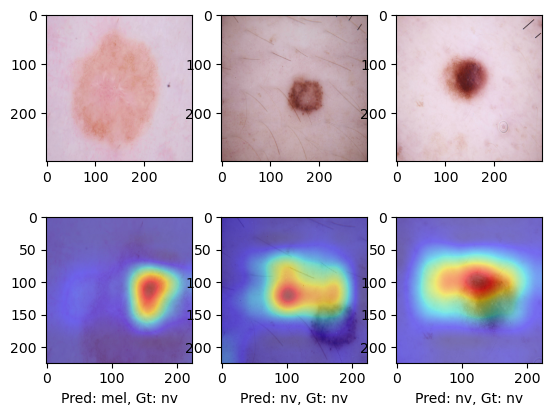

In [24]:
x_test,y_test=test_batches[70]



sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
img1_idx = 9
img2_idx = 4
img3_idx = 3
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
#plt.imshow(t[img_idx])
fig, axes = plt.subplots(2, 3)
axes[0,0].imshow(t[img1_idx])
axes[0,1].imshow(t[img2_idx])
axes[0,2].imshow(t[img3_idx])
#plt.show()




class_predictions = model.predict(x_test)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

###############################
prediction_index1 = np.argmax(class_predictions[9])
ground_truth_index1 = np.argmax(y_test[9])

pred1 = target_names[prediction_index1]
gt1 = target_names[ground_truth_index1]

###################################
prediction_index2 = np.argmax(class_predictions[4])
ground_truth_index2 = np.argmax(y_test[4])

pred2 = target_names[prediction_index2]
gt2 = target_names[ground_truth_index2]

#######################################
prediction_index3 = np.argmax(class_predictions[3])
ground_truth_index3 = np.argmax(y_test[3])

pred3 = target_names[prediction_index3]
gt3 = target_names[ground_truth_index3]


#################
#fig, axes = plt.subplots(1, 3)

sum_attnmap = np.sum(sa_maps[img1_idx],0)
axes[1,0].imshow(t[img1_idx],alpha=1.0)
axes[1,0].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,0].set_xlabel(f"Pred: {pred1}, Gt: {gt1}")

sum_attnmap = np.sum(sa_maps[img2_idx],0)
axes[1,1].imshow(t[img2_idx],alpha=1.0)
axes[1,1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,1].set_xlabel(f"Pred: {pred2}, Gt: {gt2}")

sum_attnmap = np.sum(sa_maps[img3_idx],0)
axes[1,2].imshow(t[img3_idx],alpha=1.0)
axes[1,2].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,2].set_xlabel(f"Pred: {pred3}, Gt: {gt3}")

plt.show()

1/1 [==============================] - 0s 167ms/step


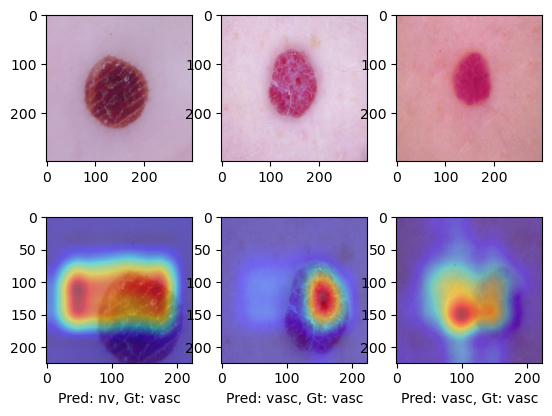

In [25]:
x_test,y_test=test_batches[124]



sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
img1_idx = 9
img2_idx = 4
img3_idx = 3
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
#plt.imshow(t[img_idx])
fig, axes = plt.subplots(2, 3)
axes[0,0].imshow(t[img1_idx])
axes[0,1].imshow(t[img2_idx])
axes[0,2].imshow(t[img3_idx])
#plt.show()




class_predictions = model.predict(x_test)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

###############################
prediction_index1 = np.argmax(class_predictions[9])
ground_truth_index1 = np.argmax(y_test[9])

pred1 = target_names[prediction_index1]
gt1 = target_names[ground_truth_index1]

###################################
prediction_index2 = np.argmax(class_predictions[4])
ground_truth_index2 = np.argmax(y_test[4])

pred2 = target_names[prediction_index2]
gt2 = target_names[ground_truth_index2]

#######################################
prediction_index3 = np.argmax(class_predictions[3])
ground_truth_index3 = np.argmax(y_test[3])

pred3 = target_names[prediction_index3]
gt3 = target_names[ground_truth_index3]


#################
#fig, axes = plt.subplots(1, 3)

sum_attnmap = np.sum(sa_maps[img1_idx],0)
axes[1,0].imshow(t[img1_idx],alpha=1.0)
axes[1,0].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,0].set_xlabel(f"Pred: {pred1}, Gt: {gt1}")

sum_attnmap = np.sum(sa_maps[img2_idx],0)
axes[1,1].imshow(t[img2_idx],alpha=1.0)
axes[1,1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,1].set_xlabel(f"Pred: {pred2}, Gt: {gt2}")

sum_attnmap = np.sum(sa_maps[img3_idx],0)
axes[1,2].imshow(t[img3_idx],alpha=1.0)
axes[1,2].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
axes[1,2].set_xlabel(f"Pred: {pred3}, Gt: {gt3}")

plt.show()

In [ ]:
sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


for i in range(len(test_batches)):
    x_test,y_test=test_batches[i]
    for j in range(len(x_test)):
        img_idx = j
        t = (x_test + 1)/2 
        fig, axes = plt.subplots(2, 1)
        axes[0].imshow(t[img_idx])
        class_predictions = model.predict(x_test)

        prediction_index = np.argmax(class_predictions[j])
        ground_truth_index = np.argmax(y_test[j])
        pred = target_names[prediction_index]
        gt = target_names[ground_truth_index]
        
        sum_attnmap = np.sum(sa_maps[img_idx],0)
        axes[1].imshow(t[img_idx],alpha=1.0)
        axes[1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
        axes[1].set_xlabel(f"Pred: {pred}, Gt: {gt}")
        
        if (pred == gt):
            plt.savefig('trueCases/plt_' + str(i) + '_' + str(j) + '.jpg')
        else: 
            plt.savefig('failCases/plt_' + str(i) + '_' + str(j) + '.jpg')
